# Self tracking
![Xiaomi-Redmi-Smart-Band-Pro.jpg](img/Xiaomi-Redmi-Smart-Band-Pro.jpg)

Image: Xiaomi Redmi Smart Band Pro.

May, 2024

> Data Analysis, Hypothesis testing

## Background
Lately, I had the feeling that I wasn't resting very well at night. Could it be because of the coffee I drink every day? Normally, it's just three cups a day (okay, sometimes four), and I've been drinking it for many years, in the morning and in the afternoon. It may have some effect, so I decided to conduct a little experiment.

I decided to track the data of my physical activity, my heart rate, and my sleep patterns with my smart wristband in two different periods: during the first one, I would continue drinking coffee as usual, and in the second one, I would stop drinking it altogether (I would stop consuming caffeine). The goal was to see if I noticed any difference in my sleep patterns between these two periods.

So, I put on my Xiaomi activity tracker and didn't take it off for 6 weeks. The first four weeks were normal (caffeinated), and the last two were the trial ones (decaffeinated).

Yes, I know, I should have extended the coffee-free period to 4 weeks to have as much a number of samples in both cases and give the experiment enough time. But it was hard, especially the first week: I noticed headaches and a lack of energy. The second week was better but I missed my beloved coffee, the punch of it in the morming, its taste having it with someone in a cafe. I think I did enough by abstaining for half a month. I love science, but not as much as coffee.

## The data
In my personal Xiaomi account, I requested the data registered by the device. Among the CSV files they provide you with, I focused on the ones aggregated by day (daily reports).

In [1]:
import datetime
import json

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


# Define some user functions for statistical tests
def bootstrap_replicate_1d(data, func):
    """Generate bootstrap replicate of 1D data."""
    bs_sample = np.random.choice(data, len(data))

    return func(bs_sample)


def draw_bs_reps(data, func, size=1):
    """Draw bootstrap replicates."""

    # Initialize array of replicates: bs_replicates
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(data, func)

    return bs_replicates


def permutation_sample(data1, data2):
    """Generate a permutation sample from two data sets."""

    # Concatenate the data sets: data
    data = np.concatenate((data1, data2))

    # Permute the concatenated array: permuted_data
    permuted_data = np.random.permutation(data)

    # Split the permuted array into two: perm_sample_1, perm_sample_2
    perm_sample_1 = permuted_data[: len(data1)]
    perm_sample_2 = permuted_data[len(data1) :]

    return perm_sample_1, perm_sample_2


def draw_perm_reps(data_1, data_2, func, size=1):
    """Generate multiple permutation replicates."""

    # Initialize array of replicates: perm_replicates
    perm_replicates = np.empty(size)

    for i in range(size):
        # Generate permutation sample
        perm_sample_1, perm_sample_2 = permutation_sample(data_1, data_2)

        # Compute the test statistic
        perm_replicates[i] = func(perm_sample_1, perm_sample_2)

    return perm_replicates


def diff_of_means(data_1, data_2):
    """Difference in means of two arrays."""

    # The difference of means of data_1, data_2: diff
    diff = np.mean(data_1) - np.mean(data_2)

    return diff


# Read file of aggregated data
band = pd.read_csv(
    "data/20240430_8158242397_MiFitness_hlth_center_aggregated_fitness_data.csv",
    usecols=["Tag", "Key", "Time", "Value"],
)

# Get daily reports only
band = band.loc[band["Tag"] == "daily_report", :].drop("Tag", axis=1)

# Convert time from Unix timestamps: the number of seconds since January 1, 1970.
band["Time"] = pd.to_datetime(band["Time"], unit="s")
band = band.rename(columns={"Time": "date"})

# Filter date range of interest for this project: [2024-03-19 -> 2024-04-30]
band = band.loc[band["date"].between("2024-03-19", "2024-04-30"), :]

band.head()

,Key,date,Value
249,valid_stand,2024-03-19,"{""count"":7}"
250,valid_stand,2024-03-20,"{""count"":13}"
251,valid_stand,2024-03-21,"{""count"":7}"
252,valid_stand,2024-03-22,"{""count"":9}"
253,valid_stand,2024-03-23,"{""count"":10}"


The available data corresponds to:

In [2]:
# Show possible keys
band["Key"].unique().tolist()

['valid_stand', 'steps', 'spo2', 'sleep', 'heart_rate', 'calories']

An important aspect of the experiment was to consistently maintain my usual habits, such as daily exercise. I go for a walk every day, and the following step-count record demonstrates that I maintained the habit consistently and at the same level throughout the process.

In [3]:
# Filter steps data
steps = band.loc[band["Key"] == "steps", ["date", "Value"]]

# Filter dates: [2024-03-19 -> 2024-04-29]
steps = steps.loc[steps["date"].between("2024-03-19", "2024-04-29"), :]

# Deploy json data from "Value" column into individual columns
steps = steps.join(steps["Value"].apply(lambda x: pd.Series(json.loads(x)))).drop(
    ["Value"], axis=1
)

# Get only number of steps
steps = steps.loc[:, ["date", "steps"]]

steps.head()

,date,steps
512,2024-03-19,10462
513,2024-03-20,6586
514,2024-03-21,2082
515,2024-03-22,4815
516,2024-03-23,4129


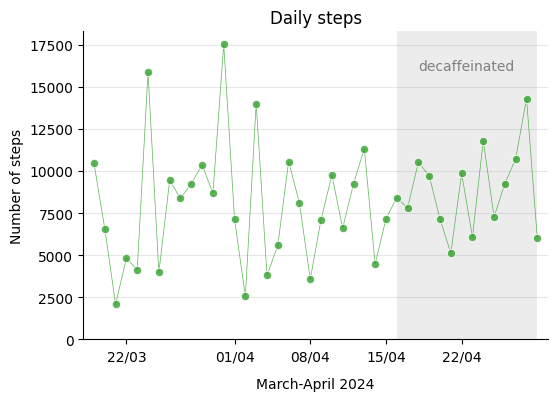

In [4]:
# Plot
fig, ax = plt.subplots(figsize=(6, 4))
palette = "Paired"
colors = sns.color_palette(palette)
sns.lineplot(
    ax=ax,
    x="date",
    y="steps",
    data=steps,
    marker="o",
    linewidth=0.5,
    color=colors[3],
    alpha=0.8,
)

ax.grid(axis="y", alpha=0.3)
ax.set_axisbelow(True)
ax.tick_params(axis="x", labelsize=10, rotation=0)
ax.set_title("Daily steps")
ax.set_xlabel("March-April 2024", labelpad=10)
ax.set_ylabel("Number of steps")
ax.xaxis.set_major_formatter(mdates.DateFormatter("%d/%m"))
ax.set_xlim([datetime.date(2024, 3, 18), datetime.date(2024, 4, 30)])
ax.set_ylim(0)
ax.axvspan(
    datetime.date(2024, 4, 16), datetime.date(2024, 4, 29), facecolor="grey", alpha=0.15
)
ax.text(datetime.date(2024, 4, 18), 16000, "decaffeinated", color="grey")
sns.despine()

plt.show()

Therefore, I kept my physical activity more or less the same during this period. Let's see how _resting heart rate_, one of the aspects that can influence sleep, evolved over those weeks.

## Heart rate
The device measures several parameters of heart rate such as maximum, minimum, and daily average, but the interesting one is the resting heart rate because supposedly it is independent of the physical activity carried out during the day.

In [5]:
# Filter heart rate data
heart = band.loc[band["Key"] == "heart_rate", ["date", "Value"]]

# Filter data: [2024-03-19 -> 2024-04-29]
heart = heart.loc[heart["date"].between("2024-03-19", "2024-04-29"), :]

# Deploy json data from "Value" column into individual columns
heart = heart.join(heart["Value"].apply(lambda x: pd.Series(json.loads(x)))).drop(
    ["Value"], axis=1
)

# Get only average resting heart rate: "avg_rhr"
heart = heart.loc[:, ["date", "avg_rhr"]]

heart.head()

,date,avg_rhr
888,2024-03-19,56
889,2024-03-20,57
890,2024-03-21,54
891,2024-03-22,57
892,2024-03-23,54


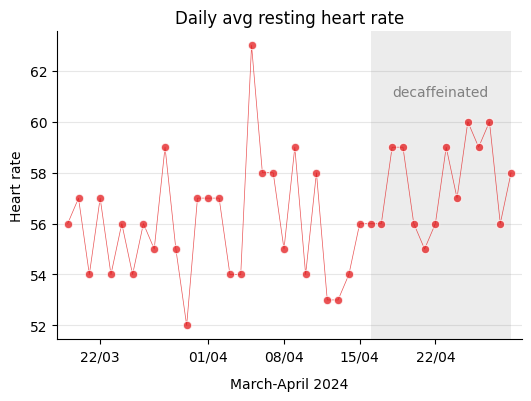

In [6]:
# Plot
fig, ax = plt.subplots(figsize=(6, 4))
sns.lineplot(
    ax=ax,
    x="date",
    y="avg_rhr",
    data=heart,
    marker="o",
    linewidth=0.5,
    color=colors[5],
    alpha=0.75,
)

ax.grid(axis="y", alpha=0.3)
ax.set_axisbelow(True)
ax.tick_params(axis="x", labelsize=10, rotation=0)
ax.set_title("Daily avg resting heart rate")
ax.set_xlabel("March-April 2024", labelpad=10)
ax.set_ylabel("Heart rate")
ax.xaxis.set_major_formatter(mdates.DateFormatter("%d/%m"))
ax.set_xlim([datetime.date(2024, 3, 18), datetime.date(2024, 4, 30)])
ax.axvspan(
    datetime.date(2024, 4, 16), datetime.date(2024, 4, 29), facecolor="grey", alpha=0.15
)
ax.text(datetime.date(2024, 4, 18), 61, "decaffeinated", color="grey")
sns.despine()

plt.show()

Just in case, I check if there's any correlation between resting heart rate and the steps taken that particular day, and as expected I find that there's no relationship at all.

In [7]:
# Join dataframes in index
steps_heart = steps.set_index("date").join(heart.set_index("date"))

# Calculate Pearson correlation coefficients
steps_heart.corr()

,steps,avg_rhr
steps,1.000000,0.045974
avg_rhr,0.045974,1.000000


I'm going to separate the data into two groups, 28 measures corresponding to the four normal weeks and 14 measures from the two caffeine-free weeks.

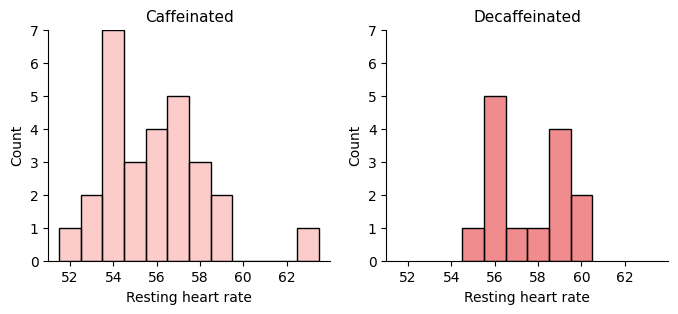

In [8]:
# Create numpy arrays of avg_rht for caffeinated (sample_a) and decaffeinated days (sample_b)
sample_a = heart.loc[
    heart["date"].between("2024-03-19", "2024-04-15"), "avg_rhr"
].to_numpy()
sample_b = heart.loc[
    heart["date"].between("2024-04-16", "2024-04-29"), "avg_rhr"
].to_numpy()

# Plot
fig, ax = plt.subplots(1, 2, figsize=(8, 3))
sns.histplot(
    sample_a, ax=ax[0], discrete=True, label="sample_a", color=colors[4], alpha=0.5
)
sns.histplot(
    sample_b, ax=ax[1], discrete=True, label="sample_b", color=colors[5], alpha=0.5
)
ax[0].set_title("Caffeinated", size=11)
ax[1].set_title("Decaffeinated", size=11)
for i in range(2):
    ax[i].set_xticks(range(52, 64, 2), labels=list(range(52, 64, 2)))
    ax[i].set_xlim(51, 64)
    ax[i].set_ylim(0, 7)
    ax[i].set_xlabel("Resting heart rate")
sns.despine()
plt.show()

Let's resample and take the means to graph their distribution.

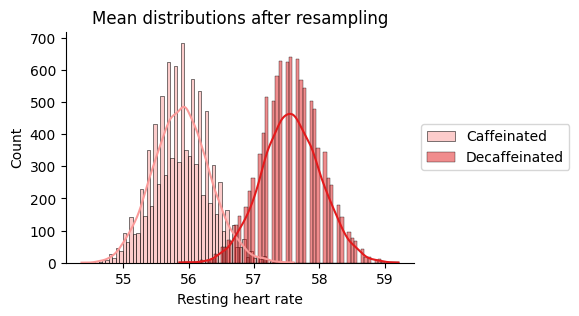

Caffeinated mean: 55.9 beats per minute
Decaffeinated mean: 57.6 beats per minute
Difference in means -> 1.7


In [9]:
# Establish random numbers' seed for reproducibility
np.random.seed(111)

# Draw bootstrap replicates and save the mean
bs_reps_sample_a_mean = draw_bs_reps(sample_a, np.mean, size=10000)
bs_reps_sample_b_mean = draw_bs_reps(sample_b, np.mean, size=10000)

# Plot
fig, ax = plt.subplots(figsize=(4.5, 3))
sns.histplot(
    bs_reps_sample_a_mean,
    ax=ax,
    kde=True,
    label="Caffeinated",
    color=colors[4],
    alpha=0.5,
)
sns.histplot(
    bs_reps_sample_b_mean,
    ax=ax,
    kde=True,
    label="Decaffeinated",
    color=colors[5],
    alpha=0.5,
)
ax.set_title("Mean distributions after resampling")
ax.set_xlabel("Resting heart rate")
ax.legend(bbox_to_anchor=(1.0, 0.5), loc="center left")
sns.despine()
plt.show()

# Compute observed means and difference
sample_a_mean = np.mean(sample_a)
sample_b_mean = np.mean(sample_b)
diff_means_observed = sample_b_mean - sample_a_mean

print(f"Caffeinated mean: {sample_a_mean:.1f} beats per minute")
print(f"Decaffeinated mean: {sample_b_mean:.1f} beats per minute")
print(f"Difference in means -> {diff_means_observed:.1f}")

There is some overlapping between the distributions. Does that mean that the observed difference is not signifficant? We will proceed to conduct two hypothesis tests:
- Bootstrapping considering equal mean values as null hypothesis-H0.
- Random permutational test as as null hypothesis-H0.

Let's start with the bootstrapping:

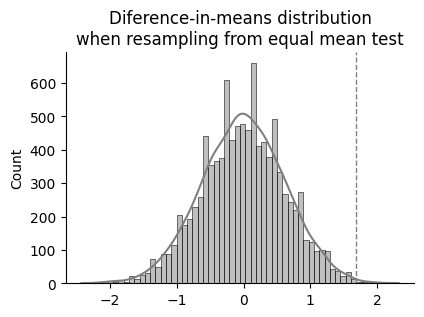

p-bootstrp = 0.0028


In [10]:
# Concatenate arrays
concat = np.concatenate((sample_a, sample_b))

# Compute mean
concat_mean = np.mean(concat)

# Generate shifted arrays
sample_a_shifted = sample_a - sample_a_mean + concat_mean
sample_b_shifted = sample_b - sample_b_mean + concat_mean

# Establish random numbers' seed for reproducibility
np.random.seed(111)

# Compute 10,000 bootstrap replicates from shifted arrays
bs_reps_sample_a_shifted_mean = draw_bs_reps(sample_a_shifted, np.mean, size=10000)
bs_reps_sample_b_shifted_mean = draw_bs_reps(sample_b_shifted, np.mean, size=10000)

# Get replicates of difference of means: bs_replicates
bs_reps = bs_reps_sample_b_shifted_mean - bs_reps_sample_a_shifted_mean

# Plot
fig, ax = plt.subplots(figsize=(4.5, 3))
sns.histplot(bs_reps, ax=ax, kde=True, color="grey", alpha=0.5)
ax.set_title("Diference-in-means distribution\nwhen resampling from equal mean test")
ax.axvline(diff_means_observed, linestyle="--", color="grey", linewidth=1)
sns.despine()
plt.show()

# Compute p-value
p = np.sum(bs_reps >= diff_means_observed) / len(bs_reps)
print(f"p-bootstrp = {p}")

So after centering both sample distributions around the same mean and bootstrapping 10000 times, only 28 times the difference between mean values of each group was equal or higher than the observed difference. That is to say, the probability of observing this difference if stopping the caffeine intake had no influence in the resting heart rate would be of just 0.28 %.

Let's see what happens with the random permutational test, which is more restrictive that the previous bootstrapping test.

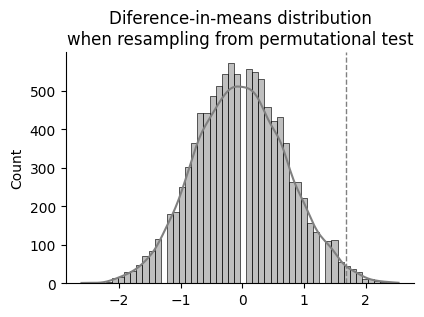

p-perm = 0.0143


In [11]:
# Establish random numbers' seed for reproducibility
np.random.seed(111)

# Draw permutation replicates
perm_reps = draw_perm_reps(sample_b, sample_a, diff_of_means, size=10000)

# Plot
fig, ax = plt.subplots(figsize=(4.5, 3))
sns.histplot(perm_reps, ax=ax, kde=True, color="grey", alpha=0.5)
ax.set_title("Diference-in-means distribution\nwhen resampling from permutational test")
ax.axvline(diff_means_observed, linestyle="--", color="grey", linewidth=1)
sns.despine()
plt.show()

# Compute the p-value: p-val
p = np.sum(perm_reps >= diff_means_observed) / len(perm_reps)
print(f"p-perm = {p}")

So after randomly scrambling (permutating) the data from the two groups 10000 times and making two groups each time, 143 times the difference between mean values of each group was equal or higher than the difference among the original groups. That is to say, the probability of observing this difference if stopping the caffeine intake had no influence in the resting heart rate would be of just 1.43 %.

Therefore, does this mean that quitting caffeine increases resting heart rate?
Um, in any case I would have said the opposite: wasn't it the intake of caffeine that increased it and not the other way around?

This is where I realize that perhaps I should have allowed more time for the new caffeine-free situation to stabilize in my body. Maybe this is nothing more than the result of the transition when changing states.

But then, this is just a statistical test. If we had to make a decision about it, we would take this result into account, considering time restraints. But contemplating it as proof of a fact of an existing reality... that is more complicated. Firstly, there is this already mentioned transitory effect, I doubt that the samples are sufficiently representative. Then, the observed difference is tiny, at around the resolution of the measure. And then, many factors I was anaware of must have intervened during the days when they were taken. I am inclined to think that chance has had a lot to do with this result. But it's just my impression.

## Sleep
Let's take a look at sleep patterns.

In [12]:
# Filter sleep data
sleep = band.loc[band["Key"] == "sleep", ["date", "Value"]]

# Filter data: [2024-03-20 -> 2024-04-30]: sleep results appear in the following day!
sleep = sleep.loc[sleep["date"].between("2024-03-20", "2024-04-30"), :]

# Deploy json data from "Value" column into individual columns
sleep = sleep.join(sleep["Value"].apply(lambda x: pd.Series(json.loads(x)))).drop(
    ["Value"], axis=1
)

# Get only "deep", "light" and "rem" sleep
sleep = sleep.loc[
    :, ["date", "sleep_deep_duration", "sleep_light_duration", "sleep_rem_duration"]
]

# I Calculate total sleep duration myself to avoid naps included in the data
sleep.loc[:, "total_duration"] = sleep.sum(numeric_only=True, axis=1)

sleep.head()

,date,sleep_deep_duration,sleep_light_duration,sleep_rem_duration,total_duration
736,2024-03-20,148,252,93,493
737,2024-03-21,214,303,26,543
738,2024-03-22,147,293,26,466
739,2024-03-23,197,340,48,585
740,2024-03-24,131,320,91,542


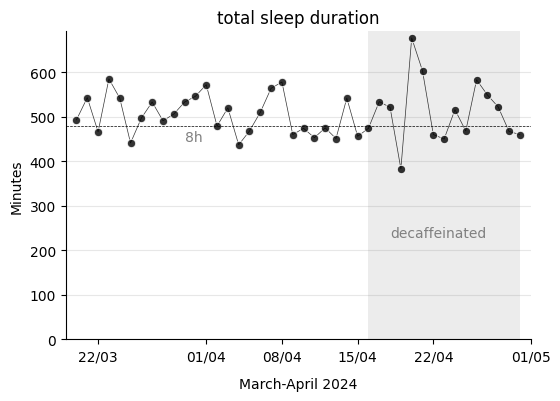

In [13]:
# Plot
fig, ax = plt.subplots(figsize=(6, 4))
sns.lineplot(
    ax=ax,
    x="date",
    y="total_duration",
    data=sleep,
    marker="o",
    linewidth=0.5,
    color="black",
    alpha=0.8,
)

ax.grid(axis="y", alpha=0.3)
ax.set_axisbelow(True)
ax.tick_params(axis="x", labelsize=10, rotation=0)
ax.set_title("total sleep duration")
ax.set_xlabel("March-April 2024", labelpad=10)
ax.set_ylabel("Minutes")
ax.xaxis.set_major_formatter(mdates.DateFormatter("%d/%m"))
ax.set_xlim([datetime.date(2024, 3, 19), datetime.date(2024, 5, 1)])
ax.axvspan(
    datetime.date(2024, 4, 16), datetime.date(2024, 4, 30), facecolor="grey", alpha=0.15
)
ax.text(datetime.date(2024, 4, 18), 230, "decaffeinated", color="grey")
ax.text(datetime.date(2024, 3, 30), 445, "8h", color="grey")
ax.set_ylim(0)
ax.axhline(480, linestyle="--", color="black", linewidth=0.5)  # 480min = 8h
sns.despine()

plt.show()

I have to warn that I have noticed that the Xiaomi smartband does not accurately monitor sleep. For example, what happened on April 20th, when it recorded that I slept for 677 minutes, which is 11 hours and 17 minutes? The date corresponds to a Saturday, and the night before, Friday, I went to the cinema. If I look at the mobile app, I see the device considered that I had fallen asleep at 8:43 PM, just when I was watching the movie. It could be, yes, that I had fallen asleep. But no, that was not the case, the film was good and I remember it all. The movie was so good that I watched it without hardly moving throughout its entire duration. This is what must have confused the device, which thought I had fallen asleep (two REM stages included!). In the next screenshot from the mobile app, I can clearly see this misconstruction.

![](img/screenshot_xiaomi.jpg)

This type of error has also occurred on several days in the evening, when I lie down on the sofa at home to read before going to bed. Therefore, the hours counted as sleep are more than what actually happened. In any case, the study will focus on the proportions of sleep phases so it will not influence the result that much.

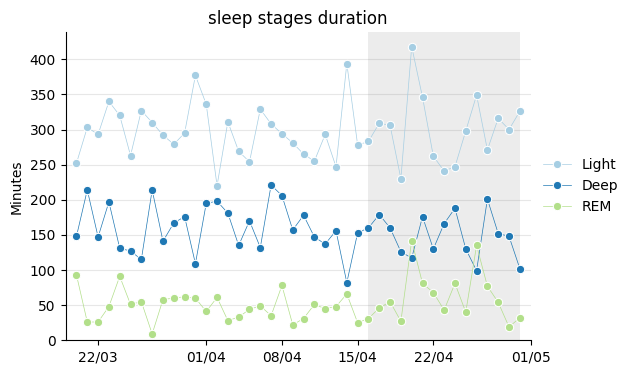

In [14]:
# Put in long format for seaborn plotting
sleeps = sleep.drop("total_duration", axis=1).melt(
    id_vars="date", var_name="type", value_name="min"
)

# Plot
fig, ax = plt.subplots(figsize=(6, 4))

hue_order = ["sleep_light_duration", "sleep_deep_duration", "sleep_rem_duration"]
sns.lineplot(
    ax=ax,
    x="date",
    y="min",
    data=sleeps,
    hue="type",
    marker="o",
    linewidth=0.5,
    palette=palette,
    hue_order=hue_order,
)

ax.grid(axis="y", alpha=0.3)
ax.set_axisbelow(True)
ax.tick_params(axis="x", labelsize=10, rotation=0)
ax.set_title("sleep stages duration")
ax.set_xlabel("")
ax.set_ylabel("Minutes")
ax.xaxis.set_major_formatter(mdates.DateFormatter("%d/%m"))
ax.set_xlim([datetime.date(2024, 3, 19), datetime.date(2024, 5, 1)])
ax.axvspan(
    datetime.date(2024, 4, 16), datetime.date(2024, 4, 30), facecolor="grey", alpha=0.15
)
ax.set_ylim(0)
ax.axhline(480, linestyle="--", color="black", linewidth=0.5)  # 480min = 8h
h, l = ax.get_legend_handles_labels()
ax.legend(
    h,
    ["Light", "Deep", "REM"],
    bbox_to_anchor=(1.0, 0.5),
    loc="center left",
    fontsize=10,
    frameon=False,
)
sns.despine()

plt.show()

The total sleep time is divided into the three usual types: light sleep, deep sleep, and REM sleep. It's interesting to see to what extent they occur in the appropriate proportions each night. The Xiaomi app recommends these:
- **Light**: between 20% and 60% of the total sleep time.
- **Deep**: between 20% and 40% of the total sleep time.
- **REM**: between 20% and 40% of the total sleep time.

Let's see if they stay inside the margins.

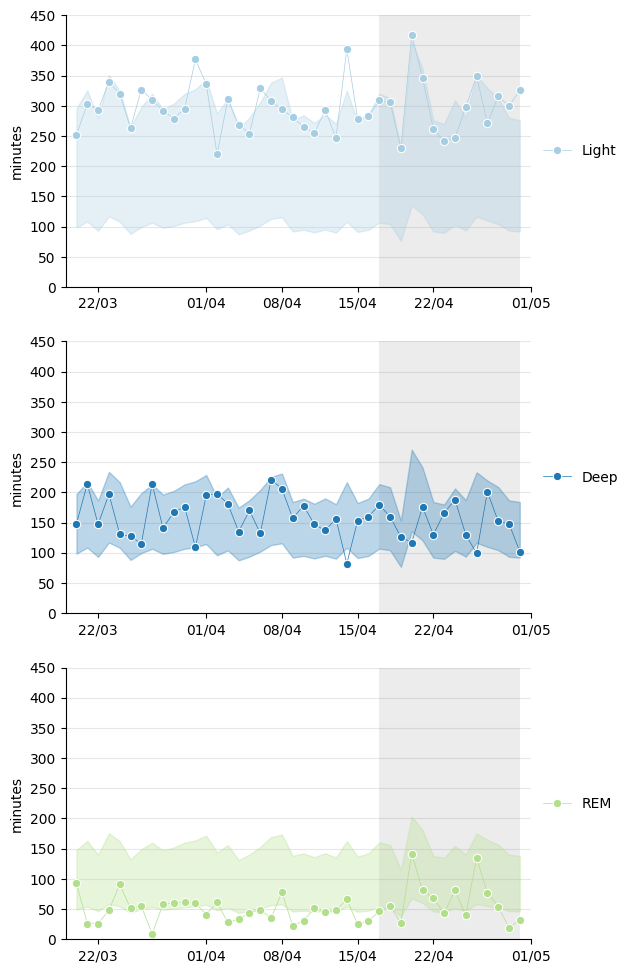

In [15]:
# Recommended ratios with respect to sleep total duration
deep_min_r = 0.2
deep_max_r = 0.4
light_min_r = 0.2
light_max_r = 0.6
rem_min_r = 0.1
rem_max_r = 0.3

# Create new columns with max and min values for each sleep phase
sleep.loc[:, "deep_min"] = sleep["total_duration"] * deep_min_r
sleep.loc[:, "deep_max"] = sleep["total_duration"] * deep_max_r
sleep.loc[:, "light_min"] = sleep["total_duration"] * light_min_r
sleep.loc[:, "light_max"] = sleep["total_duration"] * light_max_r
sleep.loc[:, "rem_min"] = sleep["total_duration"] * rem_min_r
sleep.loc[:, "rem_max"] = sleep["total_duration"] * rem_max_r

# Subset dataframe for independent plotting
deep = sleep.loc[:, ["date", "sleep_deep_duration", "deep_min", "deep_max"]]
light = sleep.loc[:, ["date", "sleep_light_duration", "light_min", "light_max"]]
rem = sleep.loc[:, ["date", "sleep_rem_duration", "rem_min", "rem_max"]]

# Plot
fig, ax = plt.subplots(3, 1, figsize=(6, 12))
sns.lineplot(
    ax=ax[0],
    x="date",
    y="sleep_light_duration",
    data=light,
    marker="o",
    linewidth=0.5,
    color=colors[0],
    label="Light",
)
sns.lineplot(
    ax=ax[1],
    x="date",
    y="sleep_deep_duration",
    data=deep,
    marker="o",
    linewidth=0.5,
    color=colors[1],
    label="Deep",
)
sns.lineplot(
    ax=ax[2],
    x="date",
    y="sleep_rem_duration",
    data=rem,
    marker="o",
    linewidth=0.5,
    color=colors[2],
    label="REM",
)

for i in range(3):
    ax[i].grid(axis="y", alpha=0.3)
    ax[i].set_axisbelow(True)
    ax[i].tick_params(axis="x", labelsize=10, rotation=0)
    ax[i].tick_params(axis="y", labelsize=10)
    ax[i].set_title("", size=12)
    ax[i].set_xlabel("")
    ax[i].set_ylabel("minutes", size=10)
    ax[i].set_ylim(0, 450)
    ax[i].xaxis.set_major_formatter(mdates.DateFormatter("%d/%m"))
    ax[i].set_xlim([datetime.date(2024, 3, 19), datetime.date(2024, 5, 1)])
    ax[i].axvspan(
        datetime.date(2024, 4, 17),
        datetime.date(2024, 4, 30),
        facecolor="grey",
        alpha=0.15,
    )

h, l = ax[0].get_legend_handles_labels()
ax[0].legend(
    h,
    ["Light"],
    bbox_to_anchor=(1.0, 0.5),
    loc="center left",
    fontsize=10,
    frameon=False,
)
h, l = ax[1].get_legend_handles_labels()
ax[1].legend(
    h,
    ["Deep"],
    bbox_to_anchor=(1.0, 0.5),
    loc="center left",
    fontsize=10,
    frameon=False,
)
h, l = ax[2].get_legend_handles_labels()
ax[2].legend(
    h, ["REM"], bbox_to_anchor=(1.0, 0.5), loc="center left", fontsize=10, frameon=False
)

ax[0].fill_between(
    sleep["date"], sleep["light_max"], sleep["light_min"], color=colors[0], alpha=0.3
)
ax[1].fill_between(
    sleep["date"], sleep["deep_max"], sleep["deep_min"], color=colors[1], alpha=0.3
)
ax[2].fill_between(
    sleep["date"], sleep["rem_max"], sleep["rem_min"], color=colors[2], alpha=0.3
)

sns.despine()

plt.show()

While deep sleep seems to typically fall within the recommended ranges, light sleep appears to lean towards the higher end and REM towards the lower end.

In the following graph, I show it in terms of ratio.

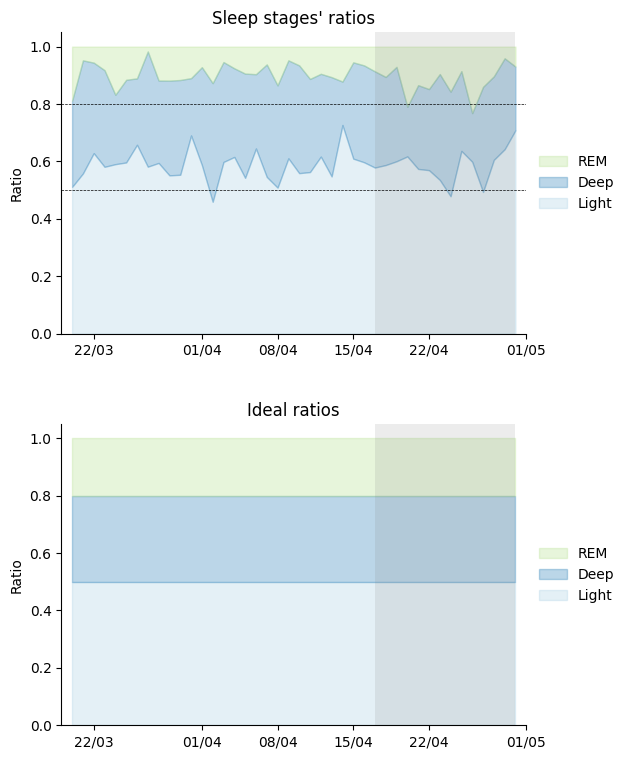

In [16]:
sleep["light_ratio"] = sleep["sleep_light_duration"] / sleep["total_duration"]
sleep["deep_ratio"] = sleep["sleep_deep_duration"] / sleep["total_duration"]
sleep["rem_ratio"] = sleep["sleep_rem_duration"] / sleep["total_duration"]

# Plot
fig, ax = plt.subplots(2, 1, figsize=(6, 9), gridspec_kw={"hspace": 0.3})

ax[0].fill_between(
    sleep["date"], sleep["light_ratio"], 0, color=colors[0], alpha=0.3, label="Light"
)
ax[0].fill_between(
    sleep["date"],
    sleep["light_ratio"] + sleep["deep_ratio"],
    sleep["light_ratio"],
    color=colors[1],
    alpha=0.3,
    label="Deep",
)
ax[0].fill_between(
    sleep["date"],
    sleep["light_ratio"] + sleep["deep_ratio"] + sleep["rem_ratio"],
    sleep["light_ratio"] + sleep["deep_ratio"],
    color=colors[2],
    alpha=0.3,
    label="REM",
)

ax[1].fill_between(sleep["date"], 0.5, 0, color=colors[0], alpha=0.3, label="Light")
ax[1].fill_between(sleep["date"], 0.8, 0.5, color=colors[1], alpha=0.3, label="Deep")
ax[1].fill_between(sleep["date"], 1, 0.8, color=colors[2], alpha=0.3, label="REM")

for i in range(2):
    ax[i].set_xlabel("")
    ax[i].set_ylabel("Ratio")
    ax[i].xaxis.set_major_formatter(mdates.DateFormatter("%d/%m"))
    ax[i].set_xlim([datetime.date(2024, 3, 19), datetime.date(2024, 5, 1)])
    ax[i].axvspan(
        datetime.date(2024, 4, 17),
        datetime.date(2024, 4, 30),
        facecolor="grey",
        alpha=0.15,
    )
    ax[i].set_ylim(0)
    h, l = ax[i].get_legend_handles_labels()
    ax[i].legend(
        [h[2], h[1], h[0]],
        [l[2], l[1], l[0]],
        bbox_to_anchor=(1.0, 0.5),
        loc="center left",
        fontsize=10,
        frameon=False,
    )

ax[0].set_title("Sleep stages' ratios")
ax[1].set_title("Ideal ratios")

ax[0].axhline(0.5, linestyle="--", color="black", linewidth=0.5)
ax[0].axhline(0.8, linestyle="--", color="black", linewidth=0.5)

sns.despine()
plt.show()

I'm clearly experiencing less REM sleep at the expense of light sleep. Could this be the reason why I feel like I haven't been sleeping very well lately? And does coffee have anything to do with it? From what I see in these graphs, it doesn't seem like anything has changed from not having caffeine, but just in case, let's take a look.

First at REM sleep:

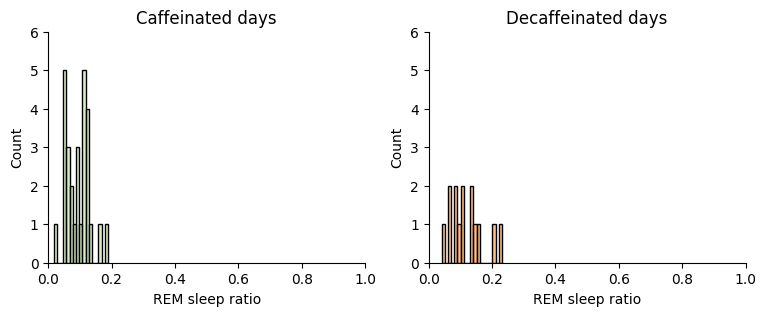

In [17]:
# Create numpy arrays of REM sleep ratios for caffeinated (sample_a) and decaffeinated days (sample_b)
sample_a = sleep.loc[
    sleep["date"].between("2024-03-20", "2024-04-16"), "rem_ratio"
].to_numpy()
sample_b = sleep.loc[
    sleep["date"].between("2024-04-17", "2024-04-30"), "rem_ratio"
].to_numpy()

# Plot
fig, ax = plt.subplots(1, 2, figsize=(9, 3))
sns.histplot(
    sample_a, ax=ax[0], binwidth=0.01, label="sample_a", color=colors[2], alpha=0.5
)
sns.histplot(
    sample_b, ax=ax[1], binwidth=0.01, label="sample_b", color=colors[7], alpha=0.5
)
ax[0].set_title("Caffeinated days")
ax[1].set_title("Decaffeinated days")
for i in range(2):
    ax[i].set_xlim(0, 1)
    ax[i].set_ylim(0, 6)
    ax[i].set_xlabel("REM sleep ratio")
sns.despine()
plt.show()

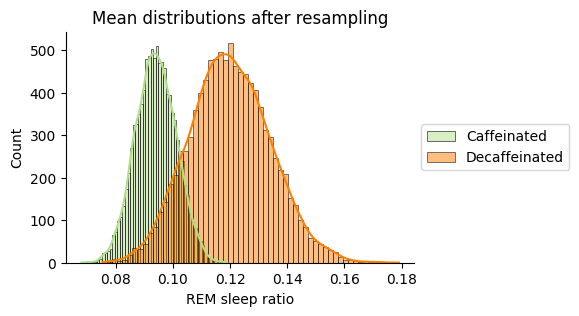

Caffeinated mean: 0.09
Decaffeinated mean: 0.12
Difference in means observed -> 0.03


In [18]:
# Establish random numbers' seed for reproducibility
np.random.seed(111)

# Draw bootstrap replicates and save the mean
bs_reps_sample_a_mean = draw_bs_reps(sample_a, np.mean, size=10000)
bs_reps_sample_b_mean = draw_bs_reps(sample_b, np.mean, size=10000)

# Plot
fig, ax = plt.subplots(figsize=(4.5, 3))
sns.histplot(
    bs_reps_sample_a_mean,
    ax=ax,
    kde=True,
    label="Caffeinated",
    color=colors[2],
    alpha=0.5,
)
sns.histplot(
    bs_reps_sample_b_mean,
    ax=ax,
    kde=True,
    label="Decaffeinated",
    color=colors[7],
    alpha=0.5,
)
ax.set_title("Mean distributions after resampling")
ax.set_xlabel("REM sleep ratio")
ax.legend(bbox_to_anchor=(1.0, 0.5), loc="center left")
sns.despine()
plt.show()

# Compute observed means and difference
sample_a_mean = np.mean(sample_a)
sample_b_mean = np.mean(sample_b)
diff_means_observed = sample_b_mean - sample_a_mean

print(f"Caffeinated mean: {sample_a_mean:.2f}")
print(f"Decaffeinated mean: {sample_b_mean:.2f}")
print(f"Difference in means observed -> {diff_means_observed:.2f}")

Decaffeinated days improve the observed REM sleep ratio but the difference is very small and the overlapping means that it is not signifficant. There is no need to do a hypothesis test.

Let's do the same with deep sleep:

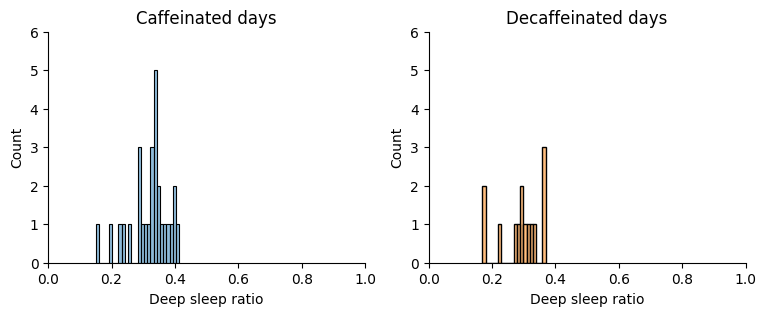

In [19]:
# Create numpy arrays of Deep sleep ratios for caffeinated (sample_a) and decaffeinated days (sample_b)
sample_a = sleep.loc[
    sleep["date"].between("2024-03-20", "2024-04-16"), "deep_ratio"
].to_numpy()
sample_b = sleep.loc[
    sleep["date"].between("2024-04-17", "2024-04-30"), "deep_ratio"
].to_numpy()

# Plot
fig, ax = plt.subplots(1, 2, figsize=(9, 3))
sns.histplot(
    sample_a, ax=ax[0], binwidth=0.01, label="sample_a", color=colors[1], alpha=0.5
)
sns.histplot(
    sample_b, ax=ax[1], binwidth=0.01, label="sample_b", color=colors[7], alpha=0.5
)
ax[0].set_title("Caffeinated days")
ax[1].set_title("Decaffeinated days")
for i in range(2):
    ax[i].set_xlim(0, 1)
    ax[i].set_ylim(0, 6)
    ax[i].set_xlabel("Deep sleep ratio")
sns.despine()
plt.show()

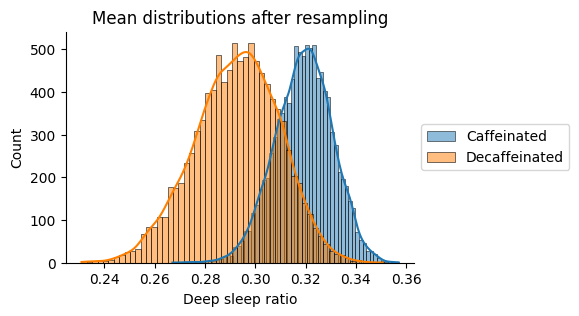

Caffeinated mean: 0.32
Decaffeinated mean: 0.29
Difference in means observed -> 0.03


In [20]:
# Establish random numbers' seed for reproducibility
np.random.seed(111)

# Draw bootstrap replicates and save the mean
bs_reps_sample_a_mean = draw_bs_reps(sample_a, np.mean, size=10000)
bs_reps_sample_b_mean = draw_bs_reps(sample_b, np.mean, size=10000)

# Plot
fig, ax = plt.subplots(figsize=(4.5, 3))
sns.histplot(
    bs_reps_sample_a_mean,
    ax=ax,
    kde=True,
    label="Caffeinated",
    color=colors[1],
    alpha=0.5,
)
sns.histplot(
    bs_reps_sample_b_mean,
    ax=ax,
    kde=True,
    label="Decaffeinated",
    color=colors[7],
    alpha=0.5,
)
ax.set_title("Mean distributions after resampling")
ax.set_xlabel("Deep sleep ratio")
ax.legend(bbox_to_anchor=(1.0, 0.5), loc="center left")
sns.despine()
plt.show()

# Compute observed means and difference
sample_a_mean = np.mean(sample_a)
sample_b_mean = np.mean(sample_b)
diff_means_observed = sample_a_mean - sample_b_mean

print(f"Caffeinated mean: {sample_a_mean:.2f}")
print(f"Decaffeinated mean: {sample_b_mean:.2f}")
print(f"Difference in means observed -> {diff_means_observed:.2f}")

Similarly, the difference in deep sleep does not seem significant.

## Conclusions
I couldn't conclude that coffee has anything to do with sleep quality. At least not with the current measuring device, the Xiaomi monitoring band is limited. Furthermore, I believe that to draw any conclusion, I should expand the number of days of the experiment, but as I said, I am not willing to do so.

Anyway, I'm glad I documented and studied this data. I'll keep looking for the reason behind my sleep patterns to find out the cause.